#### Filter submissions by three differnet languages and plot timeseries line chart shows the amounts of submission in different languages
The language detection results are returned as confidence for certain languages. The submissions in this plot are filtered by 90% confidence for each language. There are submission with lower than 90% confidence for all three languages, so the total amounts of submission will not add up to the total number of records we have.

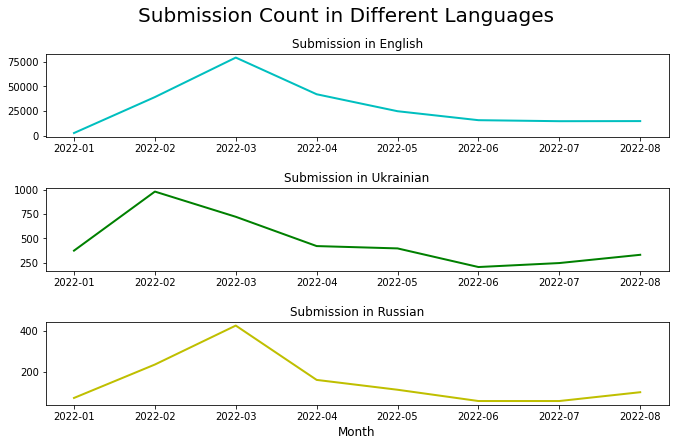

In [0]:
# import packages
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt

df_lang = spark.read.parquet("dbfs:/FileStore/tables/submissions_all_lang")
df_lang = df_lang.withColumn('timestamp', col('created_utc').cast('TimeStamp'))

def lang(r, u, e):
    
    if float(r)>0.9:
        return "russian"
    elif float(u)>0.9:
        return "ukrainian"
    elif float(e)>0.9:
        return "english"
    else:
        # language with confident lower than 90% for all three languages
        # undetermined
        return "undeter"
    
new_f = udf(lang)
    
df_lang = df_lang.withColumn("language", new_f("Russian","Ukrainian","English"))
df_lang = df_lang.withColumn('month', date_format(col('timestamp'), 'yyyy-MM'))

res = df_lang.groupBy("month","language").count()
res = res.filter(col("language") != "undeter")
res_e = res.filter(col("language") == "english").collect()
res_u = res.filter(col("language") == "ukrainian").collect()
res_r = res.filter(col("language") == "russian").collect()

res_u = pd.DataFrame(res_u)
res_u.columns=["time","language","count"]
res_e = pd.DataFrame(res_e)
res_e.columns=["time","language","count"]
res_r = pd.DataFrame(res_r)
res_r.columns=["time","language","count"]

res_r = res_r.sort_values(by=['time'])
res_e = res_e.sort_values(by=['time'])
res_u = res_u.sort_values(by=['time'])

fig, axs = plt.subplots(3, figsize=(10,6))
fig.tight_layout(pad=3.0)

axs[0].plot('time', 'count', data=res_e, marker='', color='c', linewidth=2)
axs[0].set_title("Submission in English")
axs[1].plot( 'time', 'count', data=res_u, marker='', color='g', linewidth=2)
axs[1].set_title("Submission in Ukrainian")
axs[2].plot( 'time', 'count', data=res_r, marker='', color='y', linewidth=2)
axs[2].set_title("Submission in Russian")
axs[2].set_xlabel("Month", fontsize=12)

plt.suptitle("Submission Count in Different Languages", y=1.03, fontsize=20)
# show graph
plt.show()